# Word Vector Embedding

## On 20NG, run word-verctors embedding into 300 dimensions using a Tensor Flow setup. Evaluate in two ways: 

In [30]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import xrange
import collections
import math
import string
import numpy as np
import tensorflow as tf
import random
from tensorflow.contrib.tensorboard.plugins import projector
import os
from sklearn.metrics.pairwise import euclidean_distances
from six.moves import urllib
from tempfile import gettempdir

In [2]:
# Fetch dataset
from sklearn.datasets import fetch_20newsgroups
ng_train = fetch_20newsgroups(subset = 'train')          # 11,314 datapoints in .data and category targets in .target_names

In [3]:
def clean_create_data(metafile):
    intab = string.punctuation
    outtab = " "*(len(string.punctuation ))
    trantab = str.maketrans(intab, outtab)
    metadata_words = []
    for c,file in enumerate(metafile):
        article_words = file.strip().lower().translate(trantab).split()
        for word in article_words:
            metadata_words.append(word)
    print('Length of vocabulary:', len(metadata_words))
    return metadata_words

In [4]:
vocabulary = clean_create_data(ng_train.data)

Length of vocabulary: 3703511


In [5]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [6]:
vocabulary_size = 50000

In [7]:
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)
del vocabulary

In [8]:
data_index = 0

In [9]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
#     data_index = 0
#     print('Im here',data_index)
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
#     print('span is :', span)
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
#         print('COntext words:', context_words)
#         break
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
#             print(buffer)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [10]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])

32051 lerxst -> 4294 wam
32051 lerxst -> 14 from
4294 wam -> 1348 umd
4294 wam -> 32051 lerxst
1348 umd -> 16 edu
1348 umd -> 4294 wam
16 edu -> 152 where
16 edu -> 1348 umd


In [20]:
# Build train skip gram model
batch_size = 128
embedding_size = 300  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
# valid_examples = np.random.choice(valid_window, valid_size, replace=False)
valid_examples = np.arange(50000)
# print(valid)
graph = tf.Graph()

with graph.as_default():

  # Input data.
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        
    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],\
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))
        
    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss', loss)

    # Construct the SGD optimizer using a learning rate of 1.0.
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    
    # Merge all summaries.
    merged = tf.summary.merge_all()

    # Add variable initializer.
    init = tf.global_variables_initializer()

    # Create a saver.
    saver = tf.train.Saver()

# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
    # Open a writer to write summaries.
    writer = tf.summary.FileWriter('word2vec', session.graph)

    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips,skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # Define metadata variable.
        run_metadata = tf.RunMetadata()

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
        # Feed metadata variable to session for visualizing the graph in TensorBoard.
        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict=feed_dict,
            run_metadata=run_metadata)
        average_loss += loss_val
        
        # Add returned summaries to writer in each step.
        writer.add_summary(summary, step)
        # Add metadata to visualize the graph for the last run.
        
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
            
        
#         if step % 40000 == 0:
#             sim = similarity.eval()
#             for i in xrange(valid_size):
#                 valid_word = reverse_dictionary[valid_examples[i]]
#                 top_k = 8  # number of nearest neighbors
#                 nearest = (-sim[i, :]).argsort()[1:top_k + 1]
#                 log_str = 'Nearest to %s:' % valid_word
#                 for k in range(top_k):
#                     close_word = reverse_dictionary[nearest[k]]
#                     log_str = '%s %s,' % (log_str, close_word)
#                 print(log_str)
    final_embeddings = normalized_embeddings.eval()
    
    with open('word2vec/metadata.tsv', 'w') as f:
        for i in xrange(vocabulary_size):
            f.write(reverse_dictionary[i] + '\n')
            
    # Save the model for checkpoints.
    print('Were here')
    saver.save(session, os.path.join('word2vec', 'model.ckpt'))
    print('Now Were here')
    # Create a configuration for visualizing embeddings with the labels in TensorBoard.
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join('word2vec', 'metadata.tsv')
    projector.visualize_embeddings(writer, config)
    
writer.close()

Initialized
Average loss at step  0 :  296.6644287109375
Average loss at step  2000 :  116.1294173412323
Average loss at step  4000 :  54.27878617668152
Average loss at step  6000 :  34.68334039258957
Average loss at step  8000 :  25.012741094082592
Average loss at step  10000 :  18.947680388212206
Average loss at step  12000 :  15.671234762132167
Average loss at step  14000 :  12.604504455685616
Average loss at step  16000 :  10.893289449572563
Average loss at step  18000 :  9.764178354352712
Average loss at step  20000 :  8.350656630158424
Average loss at step  22000 :  7.407019628286362
Average loss at step  24000 :  6.983927590966225
Average loss at step  26000 :  7.301887811899185
Average loss at step  28000 :  6.281792262732982
Average loss at step  30000 :  6.165466665029526
Average loss at step  32000 :  5.912233213722706
Average loss at step  34000 :  8.948707439575344
Average loss at step  36000 :  27.886362503107637
Average loss at step  38000 :  6.2360011751651765
Average l

In [22]:
embed_dist = euclidean_distances(final_embeddings)

In [24]:
word = 'you'
word_in_dict = dictionary[word]

for j in np.argsort(embed_dist[word_in_dict])[1:20]:
    print(reverse_dictionary[j])

they
we
i
ax
suck
it
vernor
067
not
2di
t
this
db
there
baen
wy1z
º
sonar
he


In [23]:
word = 'is'
word_in_dict = dictionary[word]

for j in np.argsort(embed_dist[word_in_dict])[1:20]:
    print(reverse_dictionary[j])

was
has
ax
s
does
are
be
but
vernor
konrad
db
agrep
2di
p23
suck
if
for
067
with


In [28]:
word = 'is'
word_in_dict = dictionary[word]

for j in np.argsort(embed_dist[word_in_dict])[1:20]:
    print(reverse_dictionary[j])

was
has
s
be
ax
but
are
and
i
in
does
1
if
of
you
that
they
for
b8f


In [26]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)

In [28]:
from tempfile import gettempdir

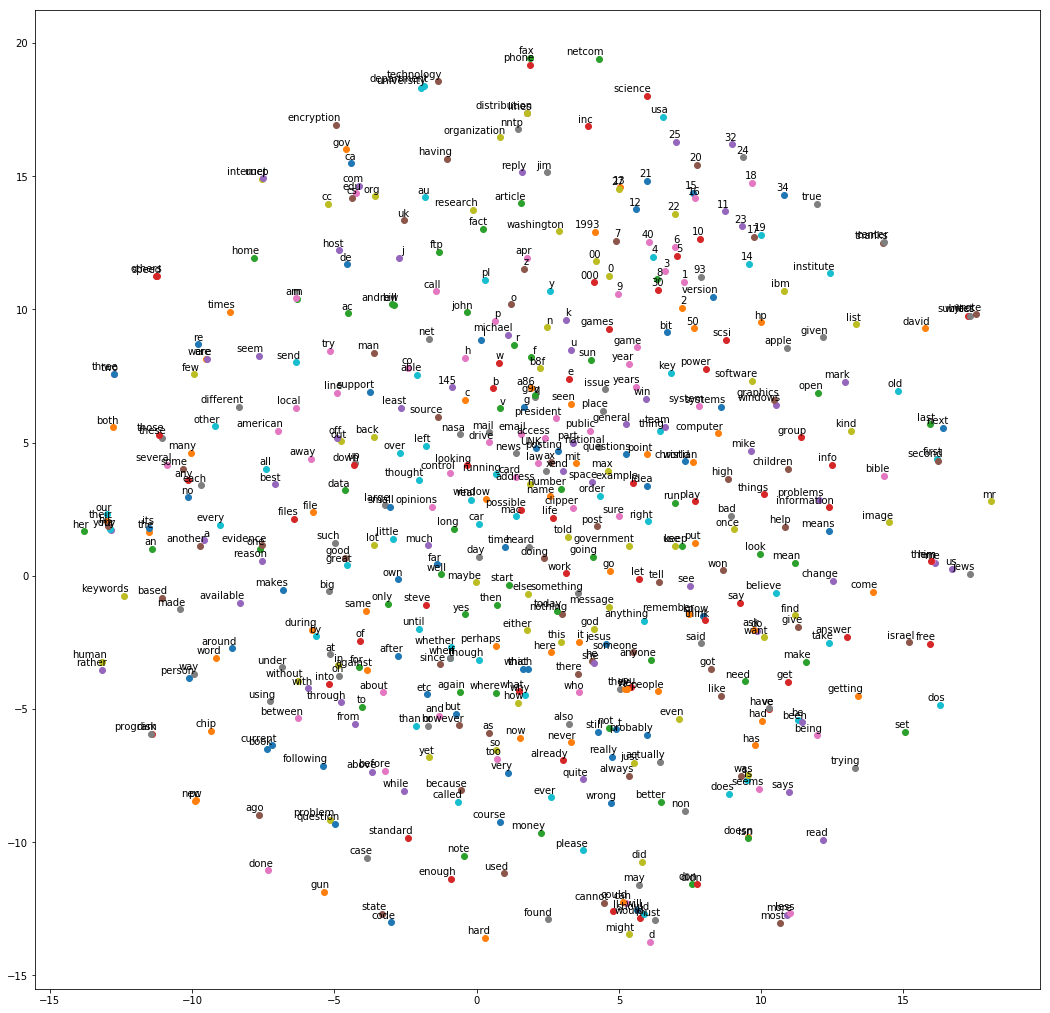

In [29]:
try:
  # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

In [38]:
similarity.shape

TensorShape([Dimension(16), Dimension(50000)])

In [39]:
valid_embeddings.shape

TensorShape([Dimension(16), Dimension(300)])